# Project for an online store

In the project, data from the online store "In One Click" was processed. The company provided 4 datasets:

- market_file.csv - contains data about customer behavior on the website, communications with the customer, and their product behavior.
- market_money.csv - data on the revenue the store receives from the customer, i.e., how much the customer has spent in total over the period of interaction with the site.
- market_time.csv - data on the time (in minutes) the customer spent on the website during the period.
- money.csv - data on the average monthly profit per customer for the last 3 months: the profit the store receives from sales to each customer.


The work is divided into parts:

1. Data loading
2. Data preprocessing
Identifying category names and standardizing them
3. Exploratory data analysis
Examining numerical and categorical attributes and their distribution
4. Data merging and analysis before modeling
Investigating data relationships
5. Modeling
Creating a pipeline to find the best model
6. Feature engineering
Identifying the most important features
7. Customer segmentation
Dividing customers into segments
Analyzing the segments

In [1]:
!pip install shap -q


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import shap

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.exceptions import FitFailedWarning
import warnings

In [3]:
warnings.filterwarnings("ignore", category=FitFailedWarning)

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Data Loading

In [5]:
market_df = pd.read_csv('../datasets/market_file.csv')
market_money_df = pd.read_csv('../datasets/market_money.csv')
market_time_df = pd.read_csv('../datasets/market_time.csv')
money_df = pd.read_csv('../datasets/money.csv', sep=';', decimal=',')

In [6]:
def df_description(df):
    print('shape: ', df.shape)
    display(df.head())
    df.info()
    display(pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm'))

In [7]:
df_description(market_df)

shape:  (1300, 13)


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,0
id,0.000000
Покупательская активность,0.000000
Тип сервиса,0.000000
Разрешить сообщать,0.000000
Маркет_актив_6_мес,0.000000
Маркет_актив_тек_мес,0.000000
Длительность,0.000000
Акционные_покупки,0.000000
Популярная_категория,0.000000
Средний_просмотр_категорий_за_визит,0.000000


In [8]:
df_description(market_money_df)

shape:  (3900, 3)


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,0
id,0.000000
Период,0.000000
Выручка,0.000000


In [9]:
df_description(market_time_df)

shape:  (2600, 3)


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,0
id,0.000000
Период,0.000000
минут,0.000000


In [10]:
df_description(money_df)

shape:  (1300, 2)


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,0
id,0.000000
Прибыль,0.000000


## Data {reprocessing

In [11]:
print('market:\n', market_df.columns, '\nmarket_money:\n', market_money_df.columns,\
      '\nmarket_time:\n', market_time_df.columns, '\nmoney:\n', money_df.columns)

market:
 Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object') 
market_money:
 Index(['id', 'Период', 'Выручка'], dtype='object') 
market_time:
 Index(['id', 'Период', 'минут'], dtype='object') 
money:
 Index(['id', 'Прибыль'], dtype='object')


In [12]:
market_df.columns = ['id', 'activity', 'service', 'notify', 'activity_avg_6', 'activity_current',\
                     'register_days', 'promo_share', 'pop_category', 'category_avg', \
                     'unpaid_basket', 'errors', 'pages_avg']
market_money_df.columns = ['id', 'period', 'revenue']
market_time_df.columns = ['id', 'period', 'min']
money_df.columns = ['id', 'profit']

In [13]:
def get_num_cat_attributes(df):
    return df.select_dtypes(include=['object']).columns.to_list(), df.select_dtypes(exclude=['object']).columns.to_list()

In [14]:
market_cat, market_num = get_num_cat_attributes(market_df)
market_num.remove('id')
print(market_cat, market_num)

['activity', 'service', 'notify', 'pop_category'] ['activity_avg_6', 'activity_current', 'register_days', 'promo_share', 'category_avg', 'unpaid_basket', 'errors', 'pages_avg']


In [15]:
market_money_cat, market_money_num = get_num_cat_attributes(market_money_df)
market_money_num.remove('id')
print(market_money_cat, market_money_num)
market_time_cat, market_time_num = get_num_cat_attributes(market_time_df)
market_time_num.remove('id')
print(market_time_cat, market_time_num)
money_cat, money_num = get_num_cat_attributes(money_df)
money_num.remove('id')
print(money_cat, money_num)

['period'] ['revenue']
['period'] ['min']
[] ['profit']


In [16]:
for attr in market_cat:
    print(f'{attr}: {market_df[attr].unique()}')

activity: ['Снизилась' 'Прежний уровень']
service: ['премиум' 'стандартт' 'стандарт']
notify: ['да' 'нет']
pop_category: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [17]:
market_df = market_df.apply(lambda x: x.replace({'стандартт':'стандарт'}, regex=True))

In [18]:
for attr in market_money_cat:
    print(f'{attr}: {market_money_df[attr].unique()}')

period: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [19]:
for attr in market_time_cat:
    print(f'{attr}: {market_time_df[attr].unique()}')

period: ['текущий_месяц' 'предыдцщий_месяц']


In [20]:
market_time_df = market_time_df.apply(lambda x: x.replace({'предыдцщий_месяц':'предыдущий_месяц'}, regex=True))

In [21]:
for attr in market_cat:
    print(f'{attr}: {market_df[attr].unique()}')

activity: ['Снизилась' 'Прежний уровень']
service: ['премиум' 'стандарт']
notify: ['да' 'нет']
pop_category: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [22]:
market_df.duplicated().sum()

0

In [23]:
market_money_df.duplicated().sum()

0

In [24]:
market_time_df.duplicated().sum()

0

In [25]:
money_df.duplicated().sum()

0

## Exploratory Data Analysis

In [26]:
active_users_ids = market_money_df.query('period == "препредыдущий_месяц" and revenue > 0')['id'].tolist()
len(active_users_ids)

1297

In [27]:
market_df = market_df[market_df['id'].isin(active_users_ids)]
market_df.shape

(1297, 13)

In [28]:
market_money_df = market_money_df[market_money_df['id'].isin(active_users_ids)]
market_time_df = market_time_df[market_time_df['id'].isin(active_users_ids)]
money_df = money_df[money_df['id'].isin(active_users_ids)]

In [29]:
def cat_plots(df, columns, group=None):
    if group is None:
        for col in columns:
            counts = df[col].value_counts()
            labels = counts.index.tolist()
            sizes = counts.values.tolist()

            plt.figure(figsize=(4, 4))
            plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
            plt.axis('equal')

            plt.title(f'Number of users by "{col}"')
            plt.show()
    else:
        columns.remove(group)
        unique_values = df[group].unique()
        labels_target, sizes_target = df[group].value_counts().index.tolist(), df[group].value_counts().values.tolist()
        plt.pie(sizes_target, labels=labels_target, autopct='%1.1f%%', startangle=140, labeldistance=1.05)
        plt.title(f'Number of users by "{group}"')
        plt.show()
        for col in columns:
            plt.figure(figsize=(4, 4))
            for value in unique_values:
                subset_df = df[df[group] == value]
                counts = subset_df[col].value_counts()
                labels, sizes = counts.index.tolist(), counts.values.tolist()

                plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, labeldistance=1.05)
                plt.title(f'Number of users by "{col}" for {group}={value}')
                plt.show()
                
                
def num_plots(df, columns, group=None):
    for col in columns:
        display(df[col].describe())
        plt.figure(figsize=(12, 6))

        if group is not None:
            plt.subplot(1, 2, 1)
            sns.boxplot(x=group, y=col, data=df)
            plt.title(f'Distribution of "{col}" by {group}')

            plt.subplot(1, 2, 2)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of "{col}"')

        else:
            plt.subplot(1, 2, 1)
            sns.boxplot(y=df[col], showfliers=False)
            plt.title(f'Distribution of "{col}"')

            plt.subplot(1, 2, 2)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of "{col}"')

        plt.tight_layout()
        plt.show()

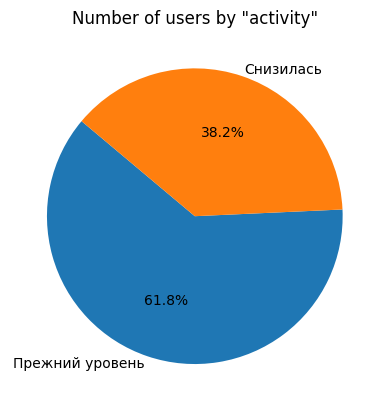

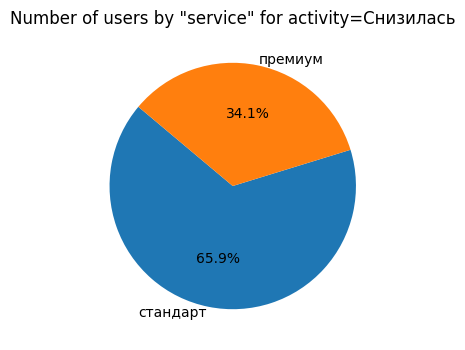

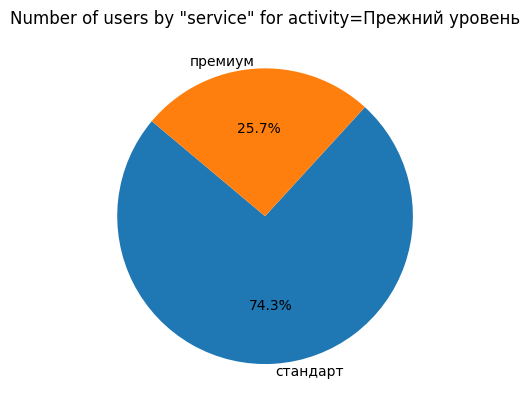

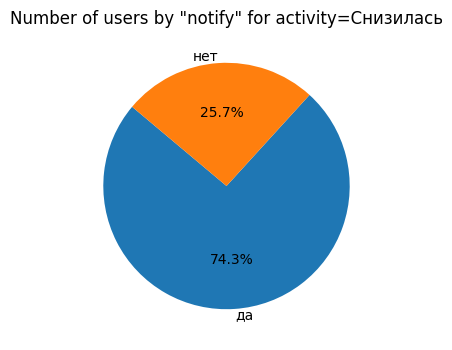

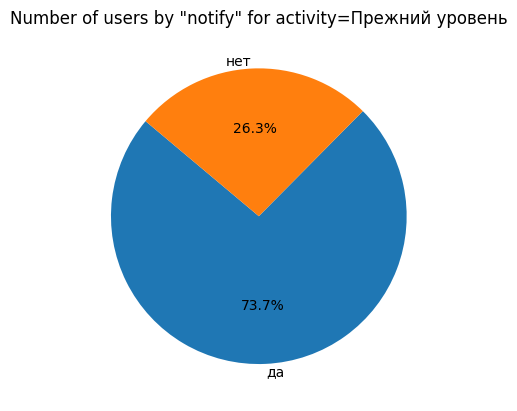

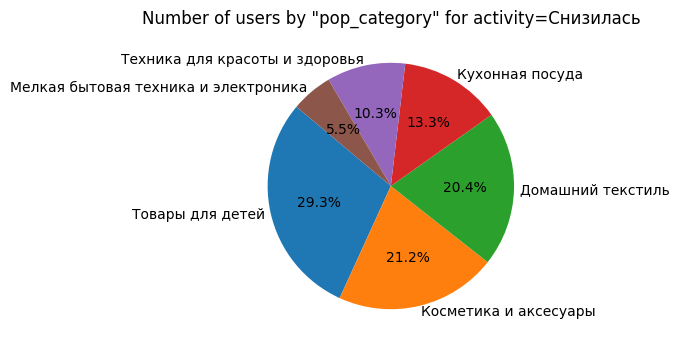

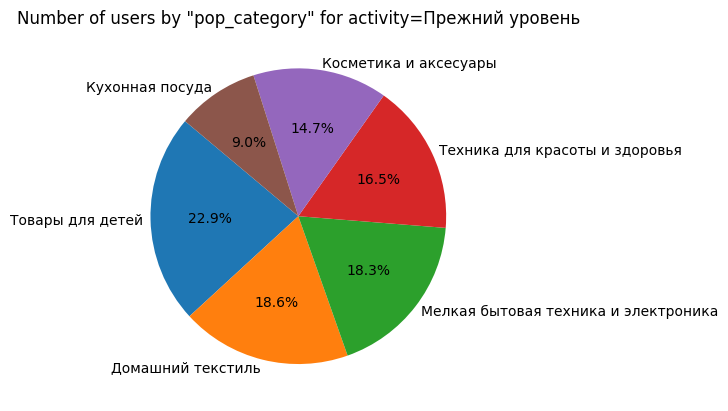

In [30]:
cat_plots(market_df, market_cat, group='activity')

count    1297.000000
mean        4.254433
std         1.015618
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: activity_avg_6, dtype: float64

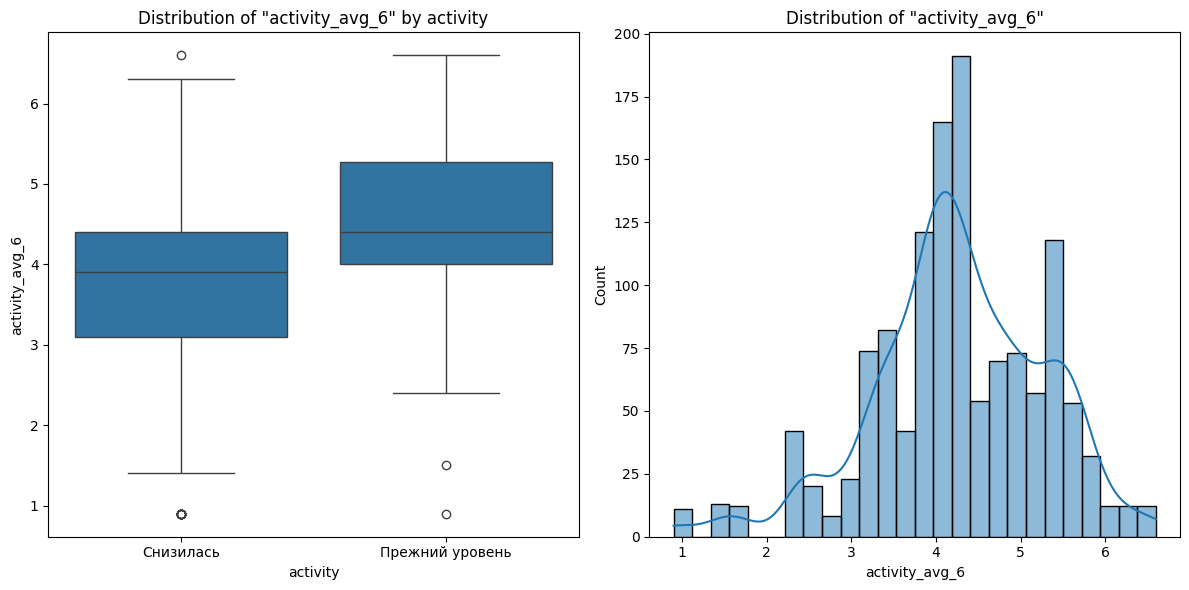

count    1297.000000
mean        4.009252
std         0.696048
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: activity_current, dtype: float64

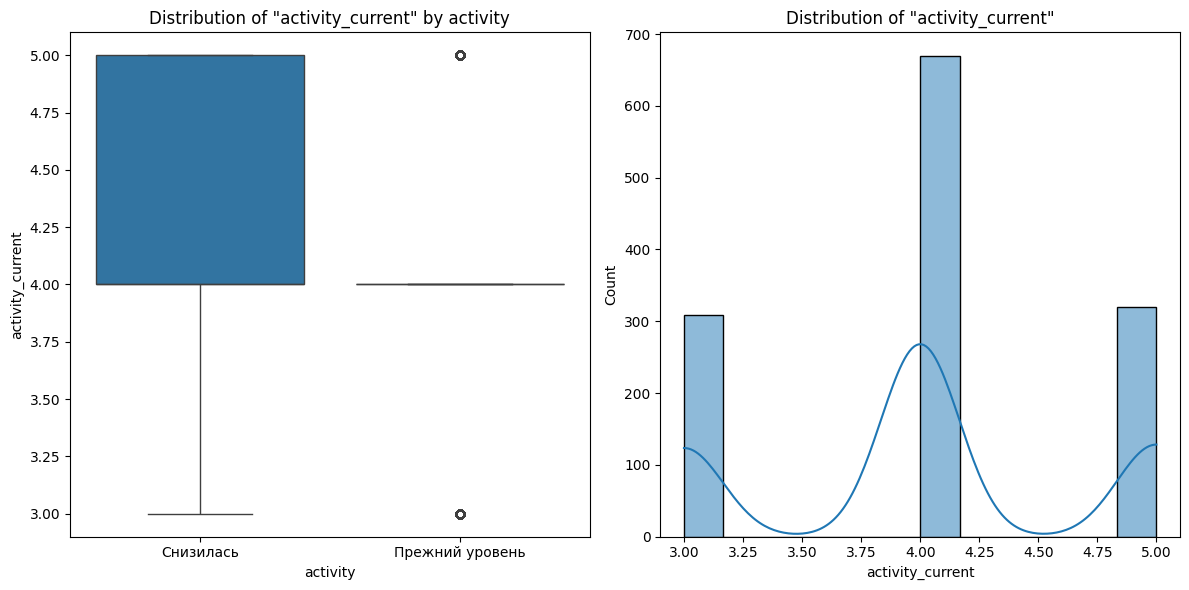

count    1297.000000
mean      602.993832
std       249.101456
min       121.000000
25%       410.000000
50%       607.000000
75%       806.000000
max      1079.000000
Name: register_days, dtype: float64

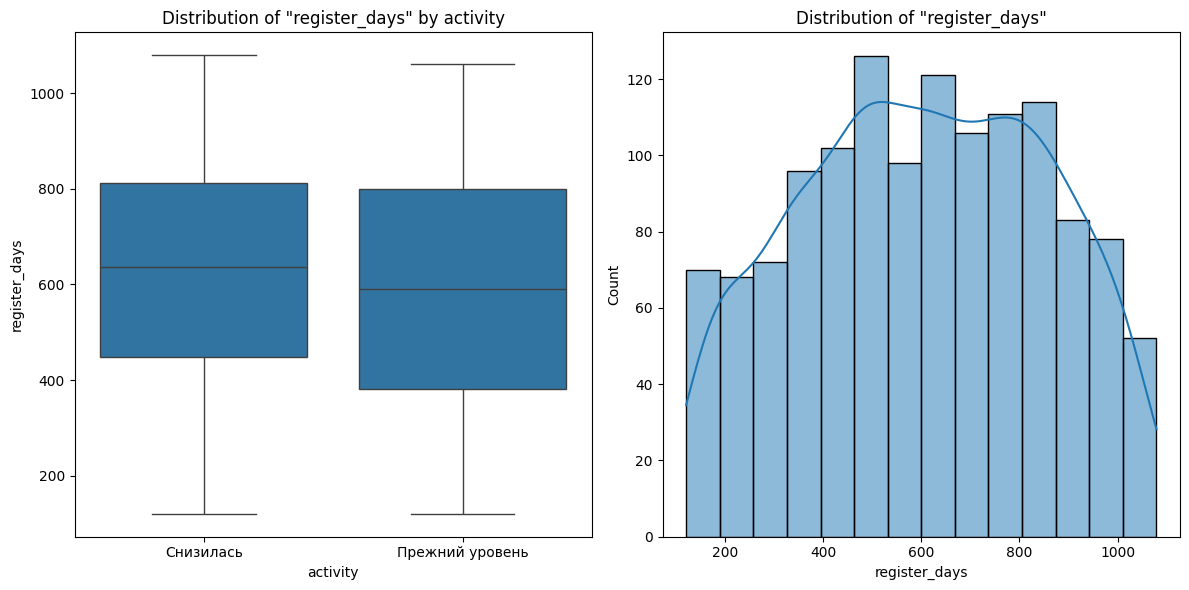

count    1297.000000
mean        0.320547
std         0.249657
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: promo_share, dtype: float64

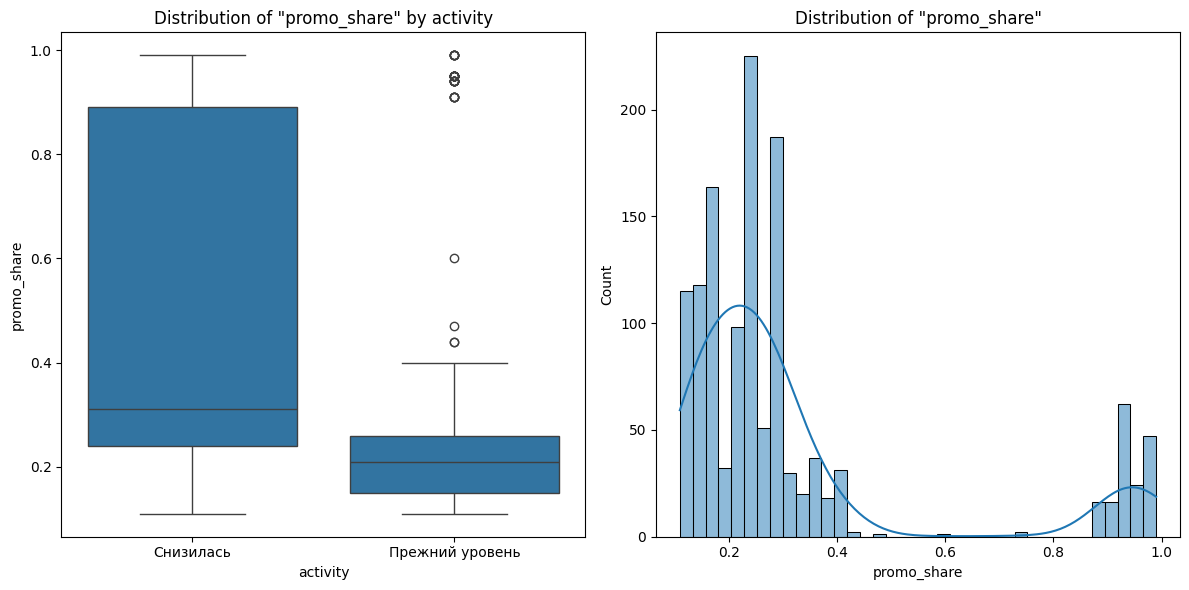

count    1297.000000
mean        3.267540
std         1.354623
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: category_avg, dtype: float64

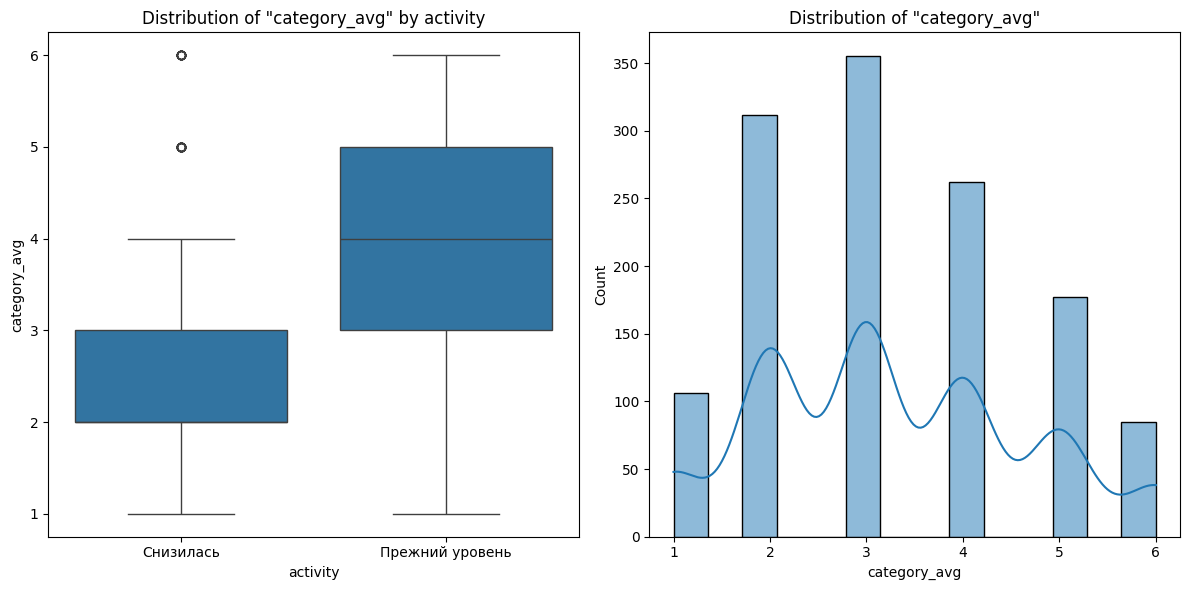

count    1297.000000
mean        2.841172
std         1.973451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: unpaid_basket, dtype: float64

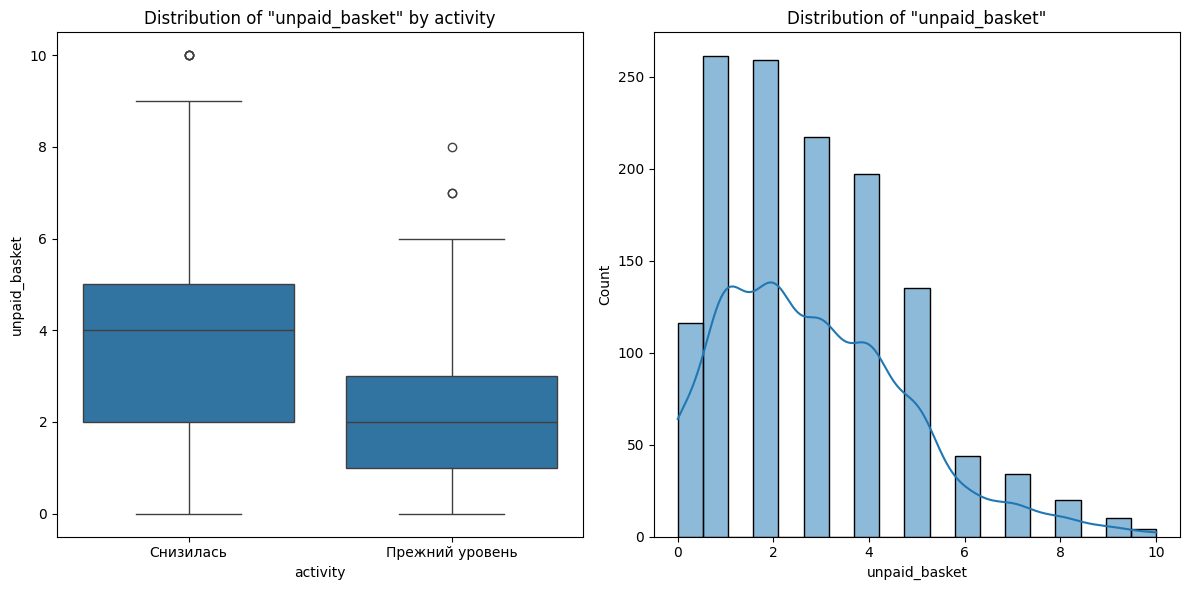

count    1297.000000
mean        4.184271
std         1.950973
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: errors, dtype: float64

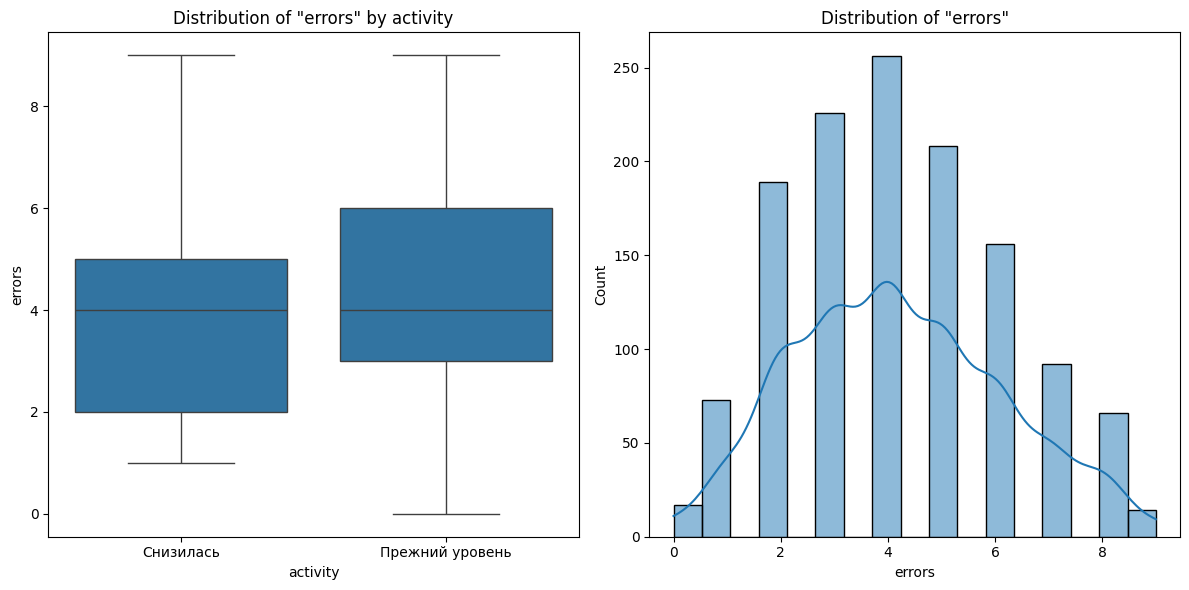

count    1297.000000
mean        8.186584
std         3.977061
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: pages_avg, dtype: float64

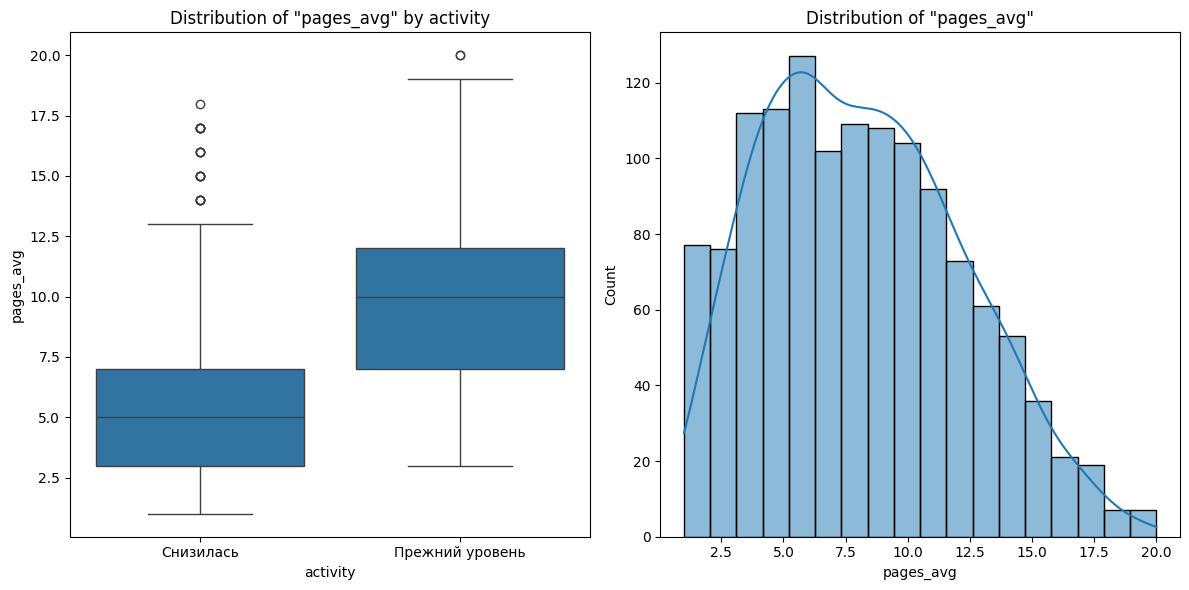

In [31]:
num_plots(market_df, market_num, group='activity')

**market_df**:
- Categorical features:
60% of customers have maintained their previous level of activity, while 40% have decreased their activity.
For both groups, the majority use the standard level of service and are subscribed to notifications.
For the "Decreased activity" group, the most popular product categories are children's products, textiles, and cosmetics and accessories. For the "Previous level" group, the most popular categories are children's products, textiles, and electronics.

- Numerical features:
The number of marketing communications for most users ranges from 3 to 6, with a peak at 4. The average values for the "Previous level" group are higher by 0.5-1 minutes.
The number of communications for the current month peaks at 4, with 3 and 5 communications for an equal number of users.
The distribution of the number of days since registration is close to normal, with values not exceeding 1080. For both groups, the values are approximately equal.
The proportion of promotional purchases is either in the range of 0.2-0.5 or 0.8-0.9. The second interval mostly applies to users with decreased activity.
The distribution of average category views resembles a normal distribution, with a peak at 3. Users with previous activity levels view almost twice as many categories on average.
The number of unpaid items mostly ranges from 1 to 6 and can reach up to 10. Higher values are observed in the "Decreased activity" group.
The distribution of the number of service errors and the number of pages visited is close to normal.


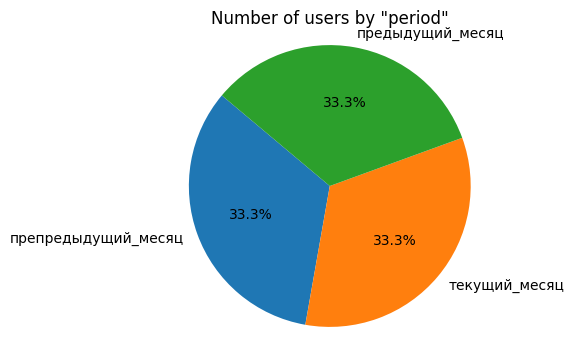

In [32]:
cat_plots(market_money_df, market_money_cat)

count      3891.000000
mean       5033.718890
std        1768.471286
min        2758.700000
25%        4592.000000
50%        4959.000000
75%        5363.200000
max      106862.200000
Name: revenue, dtype: float64

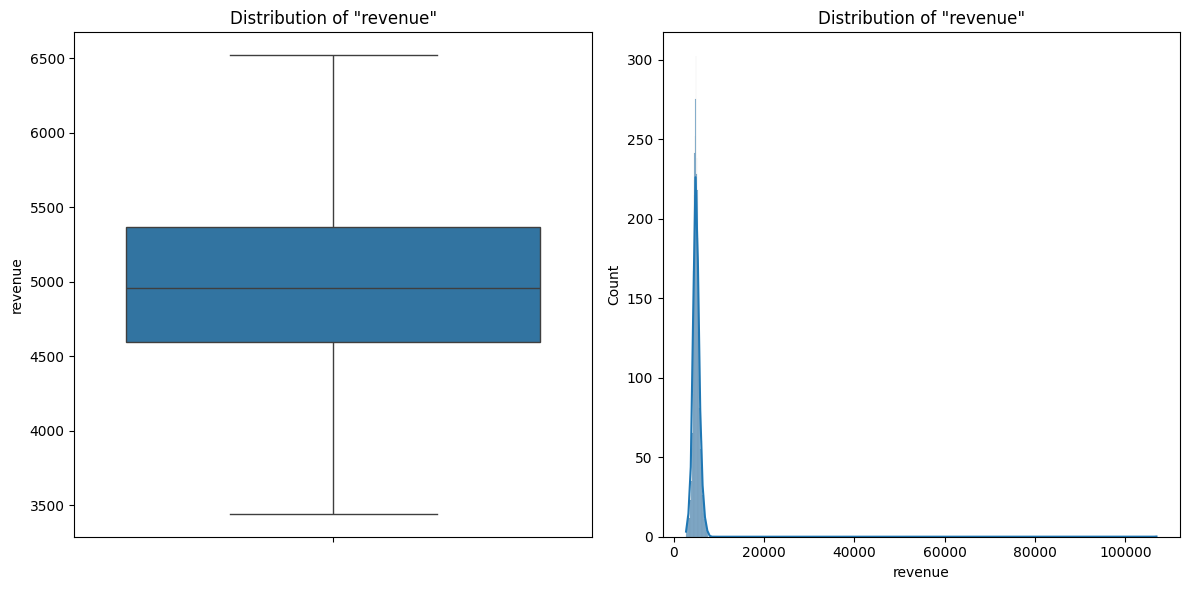

In [33]:
num_plots(market_money_df, market_money_num)

count    3890.000000
mean     5007.541902
std       679.235737
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: revenue, dtype: float64

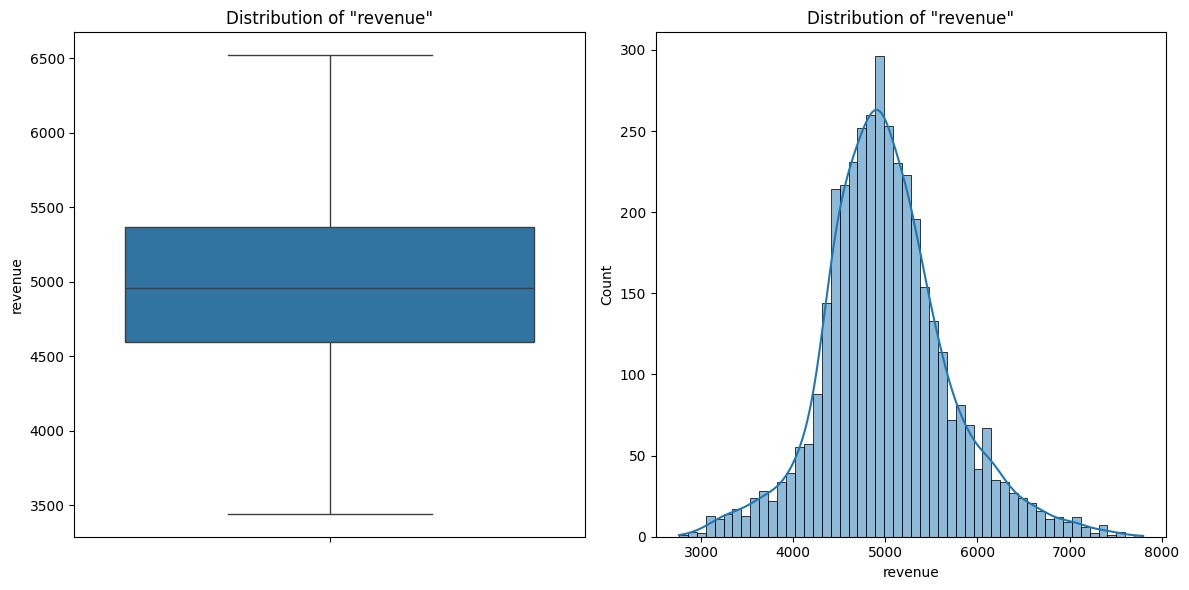

In [34]:
market_money_df = market_money_df.query('revenue < 100000')
num_plots(market_money_df, market_money_num)

**market_money_df**:
- Categorical features:
An equal number of users across periods.

- Numerical features:
The profit distribution is normal. Most values fall within the range of 4000 to 6000.


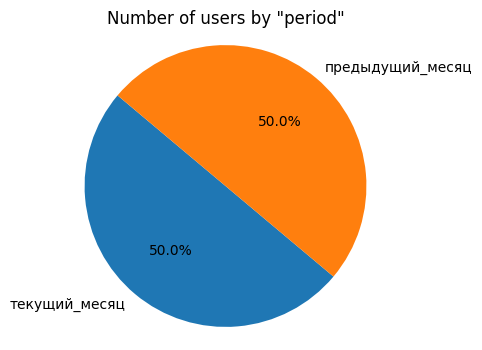

In [35]:
cat_plots(market_time_df, market_time_cat)

count    2594.000000
mean       13.340401
std         4.081999
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: min, dtype: float64

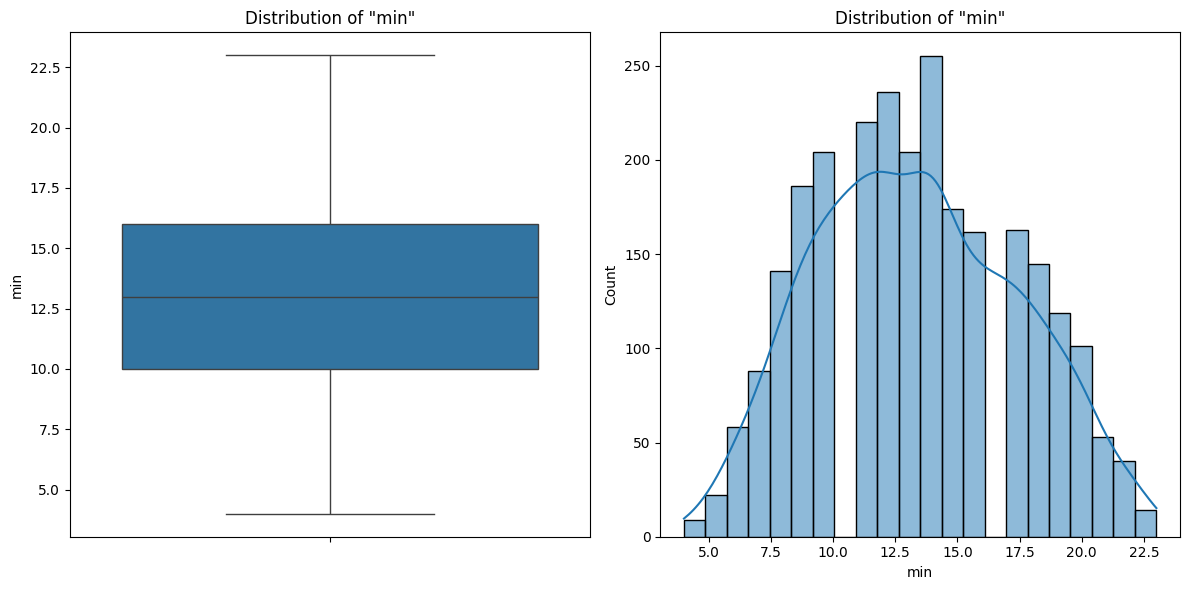

In [36]:
num_plots(market_time_df, market_time_num)

**market_time_df**:
- Numerical features:  
The distribution of time spent on the website is normal, ranging from 4 to 23 minutes, with a peak at 13 minutes.


count    1297.000000
mean        3.997610
std         1.010813
min         0.860000
25%         3.300000
50%         4.040000
75%         4.670000
max         7.430000
Name: profit, dtype: float64

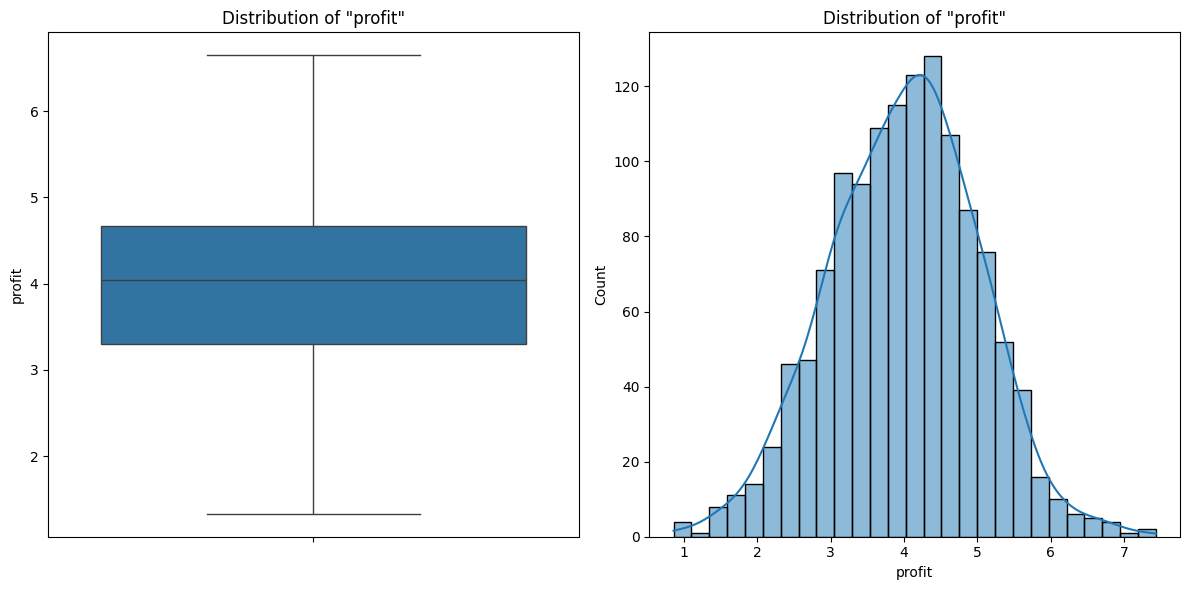

In [37]:
num_plots(money_df, money_num)

**money_df**:
- Numerical features:  
The distribution of profit from customers is normal, ranging from 0.8 to 7.4, with a peak at 4-5.

## Tables merging

In [38]:
money_pivot = market_money_df.pivot(index='id', columns='period', values='revenue')
money_pivot.reset_index(inplace=True)
money_pivot.columns=['id', 'money_prev', 'money_prev_prev', 'money_curr']
money_pivot.head(3)

,id,money_prev,money_prev_prev,money_curr
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4


In [39]:
time_pivot = market_time_df.pivot(index='id', columns='period', values='min')
time_pivot.reset_index(inplace=True)
time_pivot.columns=['id', 'time_prev', 'time_curr']
time_pivot.head(3)

,id,time_prev,time_curr
0,215349,12,10
1,215350,8,13
2,215351,11,13


In [40]:
full_df = market_df.merge(time_pivot, on='id', how='outer').merge(money_pivot, on='id', how='outer')
full_df.head(3)

,id,activity,service,notify,activity_avg_6,activity_current,register_days,promo_share,pop_category,category_avg,unpaid_basket,errors,pages_avg,time_prev,time_curr,money_prev,money_prev_prev,money_curr
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4


In [41]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1297 non-null   int64  
 1   activity          1297 non-null   object 
 2   service           1297 non-null   object 
 3   notify            1297 non-null   object 
 4   activity_avg_6    1297 non-null   float64
 5   activity_current  1297 non-null   int64  
 6   register_days     1297 non-null   int64  
 7   promo_share       1297 non-null   float64
 8   pop_category      1297 non-null   object 
 9   category_avg      1297 non-null   int64  
 10  unpaid_basket     1297 non-null   int64  
 11  errors            1297 non-null   int64  
 12  pages_avg         1297 non-null   int64  
 13  time_prev         1297 non-null   int64  
 14  time_curr         1297 non-null   int64  
 15  money_prev        1297 non-null   float64
 16  money_prev_prev   1297 non-null   float64


In [42]:
full_df = full_df.dropna()

In [43]:
df_description(full_df)

shape:  (1296, 18)


,id,activity,service,notify,activity_avg_6,activity_current,register_days,promo_share,pop_category,category_avg,unpaid_basket,errors,pages_avg,time_prev,time_curr,money_prev,money_prev_prev,money_curr
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5


<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1296 non-null   int64  
 1   activity          1296 non-null   object 
 2   service           1296 non-null   object 
 3   notify            1296 non-null   object 
 4   activity_avg_6    1296 non-null   float64
 5   activity_current  1296 non-null   int64  
 6   register_days     1296 non-null   int64  
 7   promo_share       1296 non-null   float64
 8   pop_category      1296 non-null   object 
 9   category_avg      1296 non-null   int64  
 10  unpaid_basket     1296 non-null   int64  
 11  errors            1296 non-null   int64  
 12  pages_avg         1296 non-null   int64  
 13  time_prev         1296 non-null   int64  
 14  time_curr         1296 non-null   int64  
 15  money_prev        1296 non-null   float64
 16  money_prev_prev   1296 non-null   float64
 17  

,0
id,0.000000
activity,0.000000
service,0.000000
notify,0.000000
activity_avg_6,0.000000
activity_current,0.000000
register_days,0.000000
promo_share,0.000000
pop_category,0.000000
category_avg,0.000000


In [44]:
full_df.duplicated().sum()

0

## Correlation Analysis

In [45]:
full_cat, full_num = get_num_cat_attributes(full_df)
full_num.remove('id')
print(full_cat, full_num)

['activity', 'service', 'notify', 'pop_category'] ['activity_avg_6', 'activity_current', 'register_days', 'promo_share', 'category_avg', 'unpaid_basket', 'errors', 'pages_avg', 'time_prev', 'time_curr', 'money_prev', 'money_prev_prev', 'money_curr']


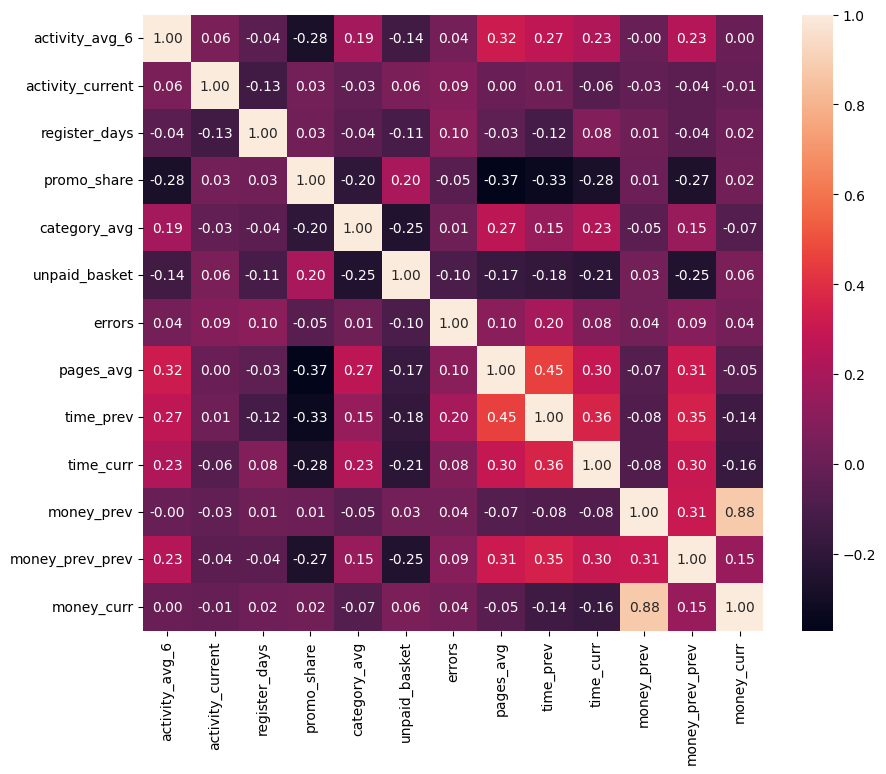

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(full_df[full_num].corr(method='spearman'), annot=True, fmt='.2f')
plt.show()

## Pipelines

In [47]:
full_df = full_df.set_index('id')
full_df.head(2)

,activity,service,notify,activity_avg_6,activity_current,register_days,promo_share,pop_category,category_avg,unpaid_basket,errors,pages_avg,time_prev,time_curr,money_prev,money_prev_prev,money_curr
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4


In [48]:
ohe_columns = ['service', 'notify', 'pop_category']
num_columns = ['activity_avg_6', 'activity_current', 'register_days', 'promo_share', 'category_avg', \
               'unpaid_basket', 'errors', 'pages_avg', 'time_prev', 'time_curr', 'money_prev', \
              'money_prev_prev', 'money_curr']

In [49]:
full_df['activity'].value_counts()

activity
Прежний уровень    802
Снизилась          494
Name: count, dtype: int64

In [50]:
target = full_df['activity']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)
pos_label = 'Снизилась'
y_binary_encoded = (y_encoded == label_encoder.transform([pos_label])[0]).astype(int)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    full_df.drop(['activity'], axis=1),
    y_binary_encoded,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = full_df['activity']
)

In [52]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [53]:
final_p = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', KNeighborsClassifier())
    ]
)

In [54]:
parameters = [

    {
        'models': [DecisionTreeClassifier(
            random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__ohe': [OrdinalEncoder(
            categories= [
                ['стандарт', 'премиум'],
                ['нет', 'да'],
                ['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары', \
                 'Техника для красоты и здоровья', 'Мелкая бытовая техника и электроника', 'Кухонная посуда'],
            ],
            handle_unknown='use_encoded_value', 
            unknown_value=np.nan)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__ohe': [OneHotEncoder(
            drop='first', 
            handle_unknown='error', 
            sparse_output=False)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True)],
        'models__C': range(1, 5),
        'models__kernel': ['poly', 'rbf'],
        'models__degree': range(2, 5),
        'preprocessor__ohe': [OneHotEncoder(
            drop='first', 
            handle_unknown='error', 
            sparse_output=False)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'models__max_iter': [900, 1000],
        'preprocessor__ohe': [OneHotEncoder(
            drop='first', 
            handle_unknown='error', 
            sparse_output=False)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }

]

In [55]:
search = GridSearchCV(
    final_p, 
    parameters,
    n_jobs=-1,
    cv=5, 
    scoring ='roc_auc',
    error_score='raise'
)

In [56]:
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['service',
                                                                          'notify',
                                                                          'pop_category']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['activity_avg_6',
                                                                          'activity_current',
                                                                          'register_days',
                                                                          'promo_share',
                                                                          'category_avg',
                                                                          'unpa...
                          'preprocessor__ohe': [OneHotEncoder(drop='first',
                                                              sparse_output=False)]},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 5),
                          'models__max_iter': [900, 1000],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), 'passthrough'],
                          'preprocessor__ohe': [OneHotEncoder(drop='first',
                                                              sparse_output=False)]}],
             scoring='roc_auc')

In [57]:
print('Best model and its parameters:\n\n', search.best_estimator_)

Best model and its parameters:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['service', 'notify',
                                                   'pop_category']),
                                                 ('num', StandardScaler(),
                                                  ['activity_avg_6',
                                                   'activity_current',
                                                   'register_days',
                                                   'promo_share',
                                                   'category_avg',
                                                   'unpaid_basket', 'errors',
                  

In [58]:
print('Best metric:\n\n', search.best_score_)

Best metric:

 0.9089512322239595


In [59]:
best_model = search.best_estimator_

In [60]:
probabilities = best_model.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('ROC square:', roc_auc_score(y_test, probabilities_one))

ROC square: 0.9125712898920034


The best model found using GridSearchCV is SVC(C=2, degree=2, probability=True, random_state=42).
The ROC AUC score on the training and test sets is 0.91.

## Feature importance analysis

In [61]:
preprocessor = search.best_estimator_.named_steps['preprocessor']
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['service', 'notify', 'pop_category']),
                                ('num', StandardScaler(),
                                 ['activity_avg_6', 'activity_current',
                                  'register_days', 'promo_share',
                                  'category_avg', 'unpaid_basket', 'errors',
                                  'pages_avg', 'time_prev', 'time_curr',
                                  'money_prev', 'money_prev_prev',
                                  'money_curr'])])

In [62]:
X_train_2 = preprocessor.fit_transform(X_train)
X_test_2 = preprocessor.transform(X_test)

In [63]:
preprocessor_ohe = preprocessor.named_transformers_['ohe']
feature_names = preprocessor_ohe.get_feature_names_out()
feature_names

array(['service_стандарт', 'notify_нет',
       'pop_category_Косметика и аксесуары',
       'pop_category_Кухонная посуда',
       'pop_category_Мелкая бытовая техника и электроника',
       'pop_category_Техника для красоты и здоровья',
       'pop_category_Товары для детей'], dtype=object)

In [64]:
num_columns

['activity_avg_6',
 'activity_current',
 'register_days',
 'promo_share',
 'category_avg',
 'unpaid_basket',
 'errors',
 'pages_avg',
 'time_prev',
 'time_curr',
 'money_prev',
 'money_prev_prev',
 'money_curr']

In [65]:
features = list(feature_names) + num_columns

In [66]:
X_test_2 = pd.DataFrame(X_test_2, columns=features)
X_test_2.head()

,service_стандарт,notify_нет,pop_category_Косметика и аксесуары,pop_category_Кухонная посуда,pop_category_Мелкая бытовая техника и электроника,pop_category_Техника для красоты и здоровья,pop_category_Товары для детей,activity_avg_6,activity_current,register_days,promo_share,category_avg,unpaid_basket,errors,pages_avg,time_prev,time_curr,money_prev,money_prev_prev,money_curr
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.169629,-0.034940,-0.003856,-0.678649,2.045527,-0.927589,-0.099707,0.961202,0.624051,0.894668,-1.405144,0.214194,-2.320463
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-2.866015,-0.034940,0.307182,2.517826,-0.183455,1.542593,-1.646221,-0.557143,-0.647600,-1.024488,-2.013227,-0.540665,-1.271572
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.968558,-0.034940,-0.474402,-0.759573,0.559539,-0.433553,1.962313,0.455087,1.641373,-0.544699,0.699537,-0.808993,1.304666
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.768826,-1.450017,1.794585,0.130585,0.559539,0.060484,0.415798,-0.557143,-1.156261,-1.024488,2.359246,0.453036,1.807872
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.228498,-0.034940,-1.834199,2.720134,-1.669444,-0.433553,-0.615212,-0.304085,0.369721,1.134563,0.193040,-1.145141,0.635946


In [67]:
model = search.best_estimator_.named_steps['models']
explainer = shap.Explainer(model.predict, X_train_2)

In [68]:
shap_values = explainer(X_test_2) 

PermutationExplainer explainer: 325it [03:05,  1.66it/s]                                                                                                            


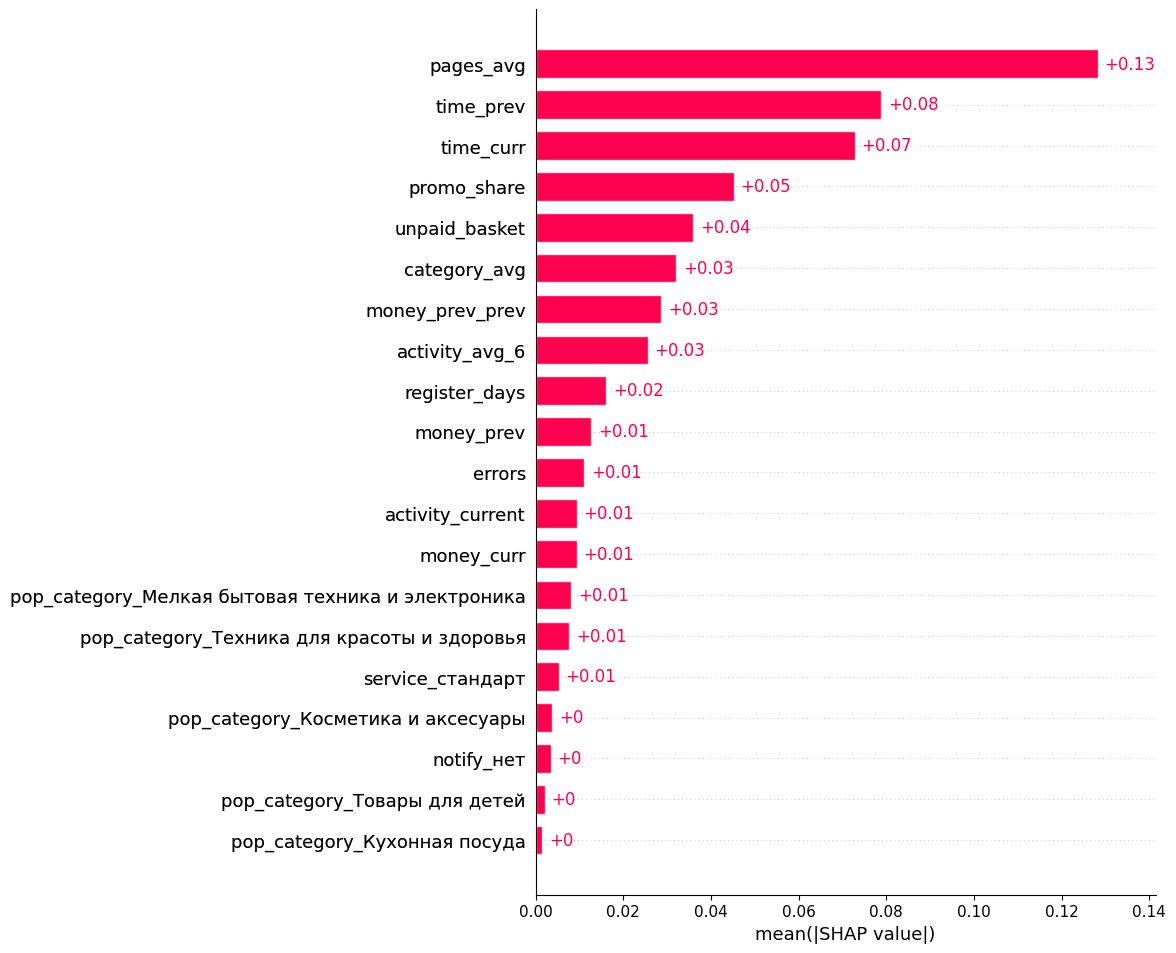

None

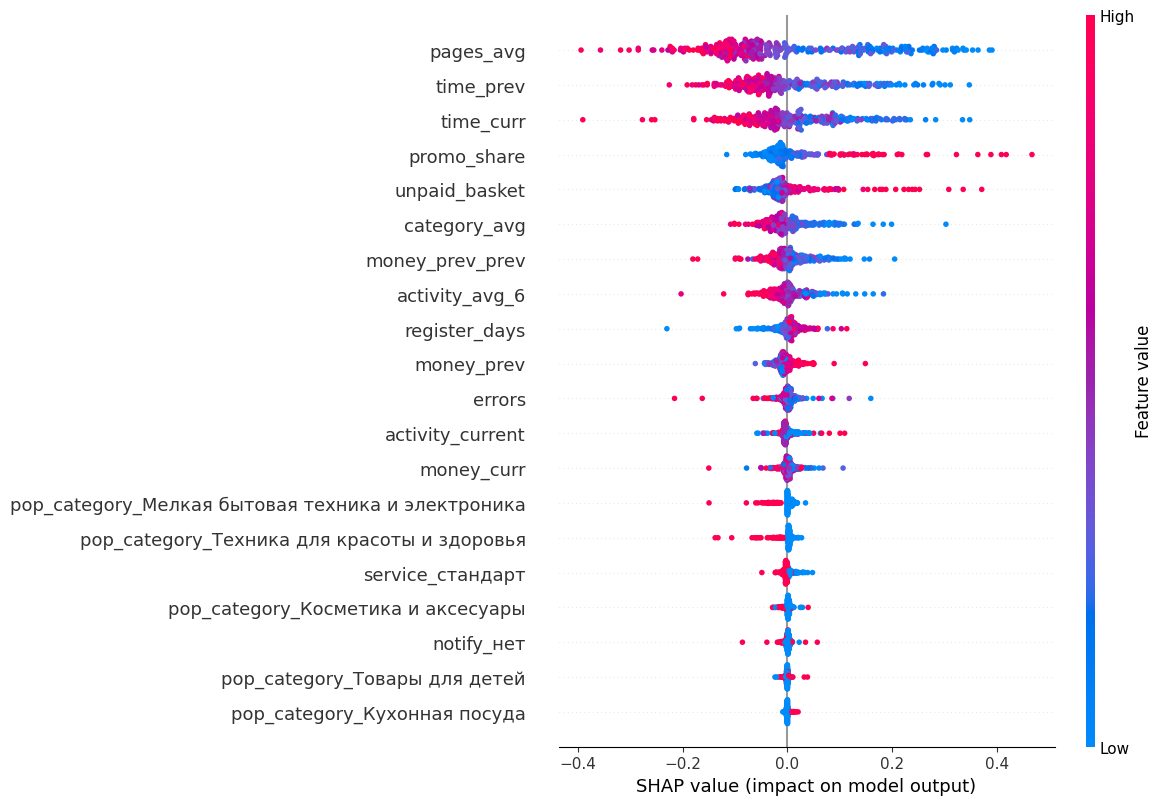

In [69]:
display(shap.plots.bar(shap_values, max_display=22))
shap.plots.beeswarm(shap_values, max_display=22)

The most important features are the average number of pages viewed and the time spent on the website in the current and previous months. The higher these values, the more likely it is that the customer's activity remains at the previous level.

High values of promotional purchases and unpaid items in the cart also have a strong impact: the likelihood of decreased activity increases.

Popular product categories, type of service, and presence of notifications do not significantly affect customer activity.

## Customers segmentation

The group of customers who buy only electronics, i.e., products with a long life cycle.


As seen in the feature importance diagram above, the presence of these categories strongly shifts the model's prediction towards class 0, which indicates previous activity. However, a clear pattern cannot be established. This is likely because people who buy electronics tend to use them for a long time, and consequently, their activity may decrease for understandable reasons.

In [70]:
clients_devices = full_df.query('pop_category == "Техника для красоты и здоровья" or pop_category == "Мелкая бытовая техника и электроника"')
clients_devices.shape

(356, 17)

In [71]:
clients_devices.head(3)

,activity,service,notify,activity_avg_6,activity_current,register_days,promo_share,pop_category,category_avg,unpaid_basket,errors,pages_avg,time_prev,time_curr,money_prev,money_prev_prev,money_curr
id,,,,,,,,,,,,,,,,,
215361,Снизилась,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,11,13,6400.0,4597.0,3789.7
215365,Снизилась,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,4,2,5,6,10,4577.0,4190.0,4799.3
215368,Снизилась,премиум,да,3.8,5,829,0.24,Техника для красоты и здоровья,2,2,6,1,11,9,5823.0,4536.0,5591.6


In [72]:
X_test_segment = clients_devices.drop(['activity'], axis=1)
y_test_segment = clients_devices['activity']

In [73]:
y_test_segment_encoded = label_encoder.transform(y_test_segment)
X_test_segment_transformed = preprocessor.transform(X_test_segment)

In [74]:
X_test_segment_transformed[0]

array([ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.8290331 , -0.03494016, -1.62684026,
       -0.35495575,  0.55953884,  1.0485568 , -1.13071646, -1.316315  ,
       -0.64760044, -0.06490974,  2.06736587, -0.71463601, -1.72492132])

In [75]:
y_pred_segment = model.predict(X_test_segment_transformed)

In [76]:
probabilities = model.predict_proba(X_test_segment_transformed)
probabilities_one = probabilities[:, 1]
print('ROC square:', roc_auc_score(y_test_segment_encoded, probabilities_one))

ROC square: 0.9536377600893731


The model performs better with customers from this segment.

Next, we will add data on their profit to the original table with customers from the segment, as well as the modeling results – the probability values of belonging to the "Decreased activity" class.

In [77]:
print(clients_devices.shape)
print(money_df.shape)
print(probabilities.shape)

(356, 17)
(1297, 2)
(356, 2)


In [78]:
clients_devices.loc[:, 'probability_1'] = probabilities[:, 1]
clients_devices.head(3)

/var/folders/4_/xr61ghq90pn4fd9d7j1yygn00000gn/T/ipykernel_9692/2851342139.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clients_devices.loc[:, 'probability_1'] = probabilities[:, 1]


,activity,service,notify,activity_avg_6,activity_current,register_days,promo_share,pop_category,category_avg,unpaid_basket,errors,pages_avg,time_prev,time_curr,money_prev,money_prev_prev,money_curr,probability_1
id,,,,,,,,,,,,,,,,,,
215361,Снизилась,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,11,13,6400.0,4597.0,3789.7,0.925080
215365,Снизилась,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,4,2,5,6,10,4577.0,4190.0,4799.3,0.862548
215368,Снизилась,премиум,да,3.8,5,829,0.24,Техника для красоты и здоровья,2,2,6,1,11,9,5823.0,4536.0,5591.6,0.988066


In [79]:
full_segment_df = clients_devices.merge(money_df, on='id', how='inner')
df_description(full_segment_df)

shape:  (356, 20)


,id,activity,service,notify,activity_avg_6,activity_current,register_days,promo_share,pop_category,category_avg,unpaid_basket,errors,pages_avg,time_prev,time_curr,money_prev,money_prev_prev,money_curr,probability_1,profit
0,215361,Снизилась,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,11,13,6400.0,4597.0,3789.7,0.925080,4.03
1,215365,Снизилась,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,4,2,5,6,10,4577.0,4190.0,4799.3,0.862548,3.65
2,215368,Снизилась,премиум,да,3.8,5,829,0.24,Техника для красоты и здоровья,2,2,6,1,11,9,5823.0,4536.0,5591.6,0.988066,6.27
3,215378,Снизилась,стандарт,да,1.7,3,488,0.39,Техника для красоты и здоровья,5,1,4,3,12,8,3543.0,4302.0,4364.6,0.899072,3.03
4,215382,Снизилась,стандарт,да,4.6,4,330,0.89,Техника для красоты и здоровья,6,2,7,6,15,8,5545.5,4824.0,6403.5,0.898153,2.42


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                356 non-null    int64  
 1   activity          356 non-null    object 
 2   service           356 non-null    object 
 3   notify            356 non-null    object 
 4   activity_avg_6    356 non-null    float64
 5   activity_current  356 non-null    int64  
 6   register_days     356 non-null    int64  
 7   promo_share       356 non-null    float64
 8   pop_category      356 non-null    object 
 9   category_avg      356 non-null    int64  
 10  unpaid_basket     356 non-null    int64  
 11  errors            356 non-null    int64  
 12  pages_avg         356 non-null    int64  
 13  time_prev         356 non-null    int64  
 14  time_curr         356 non-null    int64  
 15  money_prev        356 non-null    float64
 16  money_prev_prev   356 non-null    float64
 1

,0
id,0.000000
activity,0.000000
service,0.000000
notify,0.000000
activity_avg_6,0.000000
activity_current,0.000000
register_days,0.000000
promo_share,0.000000
pop_category,0.000000
category_avg,0.000000


### Finding ways to increase purchasing power for one group.

In [80]:
segment_sorted = full_segment_df.sort_values(by='probability_1')

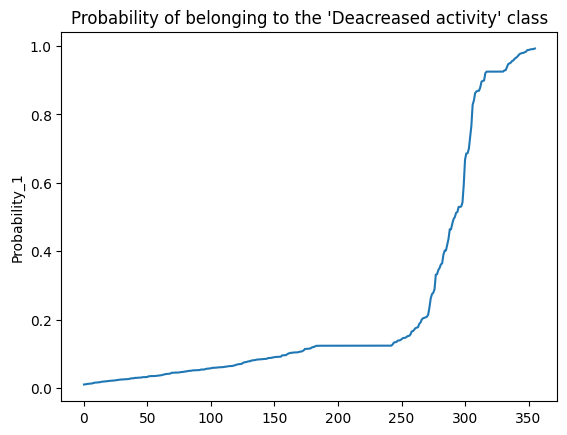

In [81]:
sns.lineplot(x=range(len(segment_sorted)), y='probability_1', data=segment_sorted)

plt.ylabel('Probability_1')
plt.title("Probability of belonging to the 'Deacreased activity' class")

plt.show()

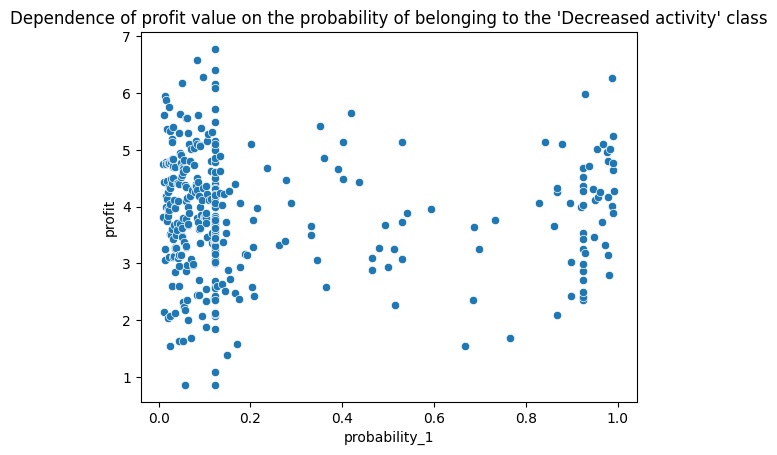

In [82]:
sns.scatterplot(data=segment_sorted, x="probability_1", y="profit").set(title="Dependence of profit value on the probability of belonging to the 'Decreased activity' class");

From the graph, we see that the range of profit values is lower for higher probabilities. However, it cannot be said that customers with high profit values definitively belong to the previous activity level class. For the previous level, the profit value range is quite large.

In [83]:
segment_sorted_cat, segment_sorted_num = get_num_cat_attributes(segment_sorted)
segment_sorted_num.remove('id')

print(segment_sorted_num, segment_sorted_cat)

['activity_avg_6', 'activity_current', 'register_days', 'promo_share', 'category_avg', 'unpaid_basket', 'errors', 'pages_avg', 'time_prev', 'time_curr', 'money_prev', 'money_prev_prev', 'money_curr', 'probability_1', 'profit'] ['activity', 'service', 'notify', 'pop_category']


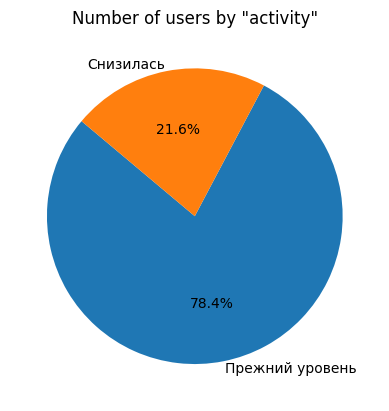

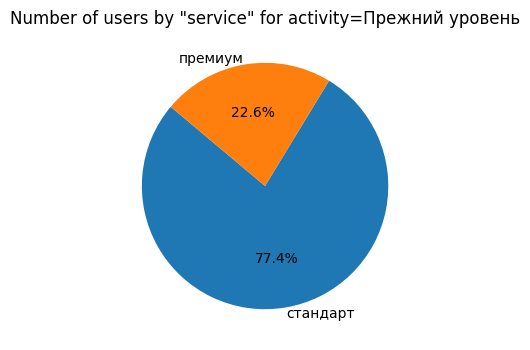

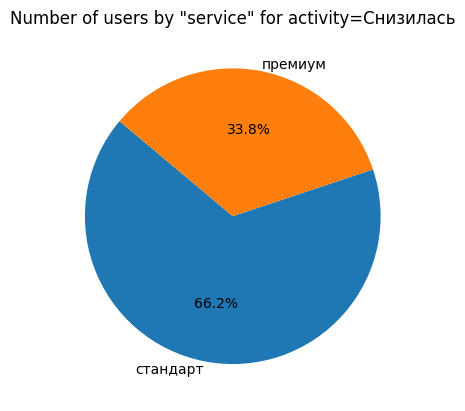

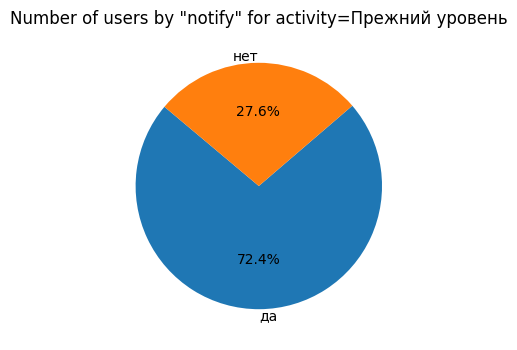

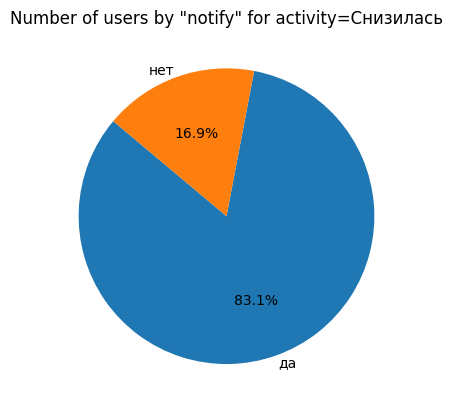

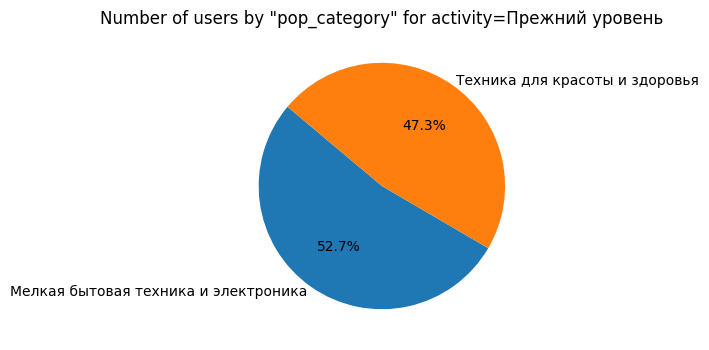

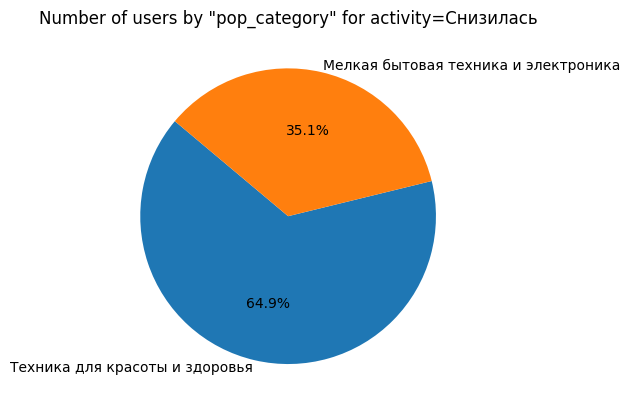

In [84]:
cat_plots(segment_sorted, segment_sorted_cat, group='activity')

In [85]:
num_plots = [ item for item in segment_sorted_num  if item != 'probability_1' and item != 'profit' ]
num_plots

['activity_avg_6',
 'activity_current',
 'register_days',
 'promo_share',
 'category_avg',
 'unpaid_basket',
 'errors',
 'pages_avg',
 'time_prev',
 'time_curr',
 'money_prev',
 'money_prev_prev',
 'money_curr']

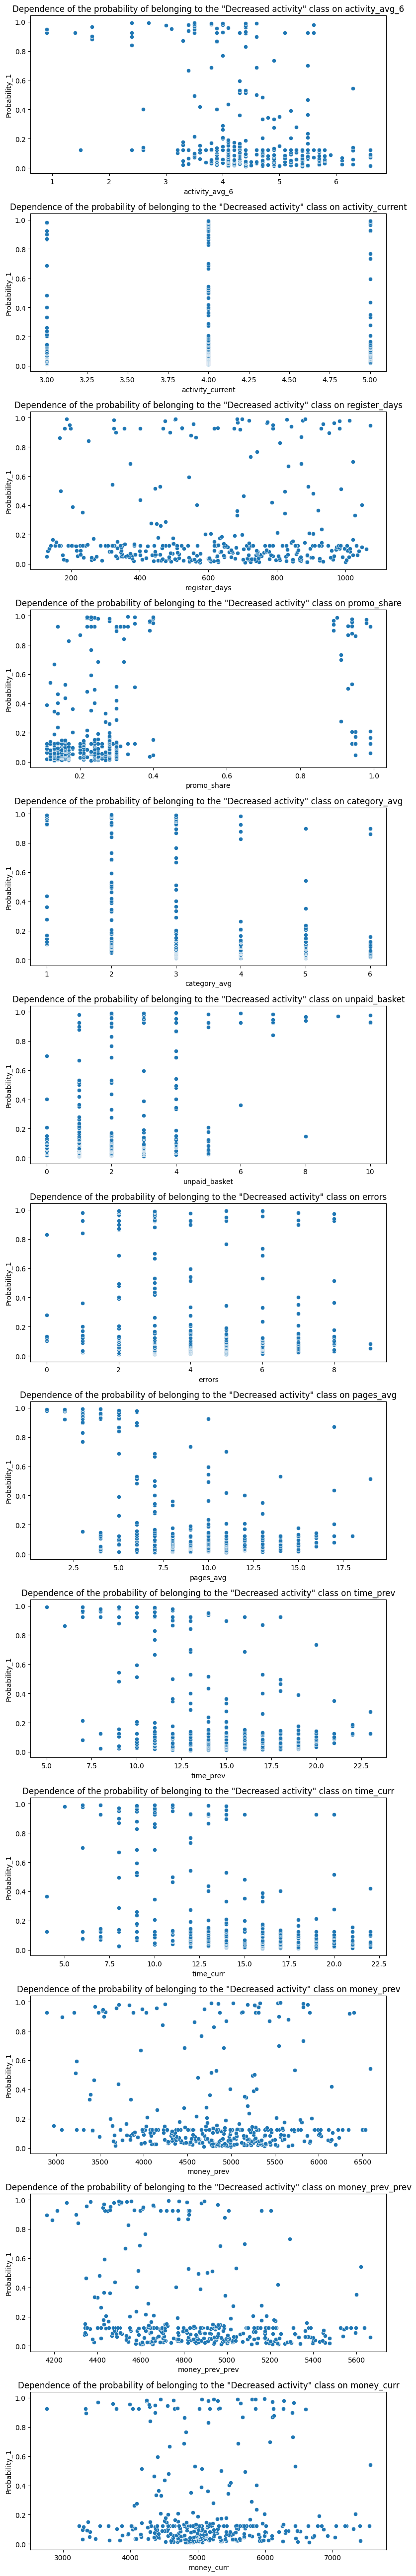

In [86]:
fig, axes = plt.subplots(nrows=len(num_plots), ncols=1, figsize=(8, 4 * len(num_plots)))

for i, attr in enumerate(num_plots):
    sns.scatterplot(data=segment_sorted, x=attr, y="probability_1", ax=axes[i])
    axes[i].set_title(f'Dependence of the probability of belonging to the "Decreased activity" class on {attr}')
    axes[i].set_xlabel(attr)
    axes[i].set_ylabel("Probability_1")

plt.tight_layout()
plt.show()   

### Segmentation summary


Not all graphs provide clear conclusions. The patterns that can be observed are:
- Lower average numbers of marketing communications over the last six months are associated with higher probability values.
- If the average number of categories viewed is greater than 3, the likelihood of decreased activity is low.
- If the number of unpaid items in the cart is more than 5, it is most likely that activity decreases.
- If a user visits fewer than 3 pages per visit, their activity decreases.
- If the average time spent on the website in the current and previous months is more than 15 minutes, it is more likely that activity remains at the previous level.

Statistics for the segment of electronics customers:
- Activity of 22% of customers has decreased
- 1/4 use premium service
- 1/4 do not use notifications
- Purchases of beauty electronics and household appliances are approximately equal

## Summary

In the course of the work, customers of the online store were analyzed.

**1. Data Preprocessing and Exploratory Data Analysis.**
At this stage, the data distribution was studied, anomalies were removed, and duplicates were checked.
Data useful for analysis, with activity of at least 3 months, were also selected.

**2. Data Merging and Correlation Analysis.**
The provided tables were merged. During the correlation analysis, a high correlation between profit values for the previous and current months was found. This was resolved by replacing the two attributes with one – their product.

**3. Modeling.**
The following algorithms and parameters were used as models for training:
- DecisionTreeClassifier
  - 'models__max_depth': range(2, 5)
  - 'models__max_features': range(2, 5)

- KNeighborsClassifier
  - 'models__n_neighbors': range(2, 5)

- SVC(random_state=RANDOM_STATE)
  - 'models__C': range(1, 5)
  - 'models__kernel': ['poly', 'rbf']
  - 'models__degree': range(2, 5)

- LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')
  - 'models__C': range(1, 5)
  - 'models__max_iter': [900, 1000]

Using GridSearchCV, the best model was found to be SVC(C=1, kernel='poly', random_state=42).

**4. Feature Importance Analysis.**
The most important features are the average number of pages viewed and the time spent on the website in the current and previous months. The higher these values, the more likely it is that the customer's activity will remain at the previous level.

High values of promotional purchases and unpaid items in the cart also have a strong impact: the likelihood of decreased activity increases.

**5. Customer Segment Analysis.**

The chosen segment was customers with the popular category "Electronics" (for beauty and household). There are 356 such customers.

To reduce the likelihood of decreased activity for this segment, it is recommended to increase the number of marketing communications with customers. 3-4 communications per month can help retain the customer.
Additionally, monitor the number of unpaid items in the cart and possibly remind the customer of the items left in the cart.
It is also necessary to keep the user on the website. For example, offer the user products similar to those they have purchased, which may interest them, so they visit more pages and spend more time on the site.